In [ ]:
import xarray as xr
import polars as pl
import glob
import pandas as pd
import re
from datetime import datetime
import os
import matplotlib.pyplot as plt
from geopy.distance import geodesic

### Open Gliders files

In [7]:


# Get list of NetCDF files
nc_files = glob.glob("C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/nc_profiled/*.nc")

# Read and concatenate datasets
for file in nc_files:
    ds = xr.open_dataset(file, decode_times=True)
    glider_name = ds.attrs.get("trajectory").split("_")[0]
    # Select variables of interest
    vars_of_interest = ["TIME", "DEPTH", "TEMP", "CHLA", "BBP700", "ABS_SALINITY", "PROFILE_NUMBER", "LATITUDE", "LONGITUDE"]
    ds_sel = ds[vars_of_interest]
    # Convert to pandas DataFrame, then to polars DataFrame
    df_pd = ds_sel.to_dataframe().reset_index()
    df_pl = pl.from_pandas(df_pd)

    #Use only profiling data (-1 is surfacing behavior)
    df_pl = df_pl.filter(pl.col("PROFILE_NUMBER") > 0)

    df_pl = df_pl.with_columns((pl.col("PROFILE_NUMBER").cast(pl.String) + "_" + glider_name).alias("profile_id"))
    print(f"{file} processed, shape: {df_pl.shape}")

    # Concatenate DataFrames
    if 'df_concat' in locals():
        df_concat = pl.concat([df_concat, df_pl])
    else:
        df_concat = df_pl


C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/nc_profiled\Cabot_645_Profiled.nc processed, shape: (1438541, 11)
C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/nc_profiled\Churchill_647_Profiled.nc processed, shape: (1142019, 11)
C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/nc_profiled\Doombar_648_Profiled.nc processed, shape: (1952630, 11)
C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/nc_profiled\Nelson_646_Profiled.nc processed, shape: (1951435, 11)


In [12]:
# Add a 'glider_name' column by extracting the part before '_' in 'profile_id'
df_concat = df_concat.with_columns(
    pl.col("profile_id").str.split("_").list.get(1).alias("glider_name")
)

### Open CTD files

In [9]:
def read_ctd(filepath):


    # Read column names from line 27 (R skips 26 lines, so read line 27 as header)
    cols = pd.read_csv(filepath, skiprows=26, nrows=0)
    cols_name = cols.columns.tolist()

    # Read actual data (R skips 28 lines, so data starts at line 29)
    dat = pd.read_csv(filepath, skiprows=28, header=None)
    dat.columns = cols_name

    # Read raw lines for metadata
    with open(filepath, "r") as f:
        raw_dat = f.readlines()

    # Extract LON
    lon_line = next(line for line in raw_dat if "LON" in line)
    lon = float(re.search(r"=(.*)", lon_line).group(1).strip())

    # Extract LAT
    lat_line = next(line for line in raw_dat if "LAT" in line)
    lat = float(re.search(r"=(.*)", lat_line).group(1).strip())

    # Add to dataframe
    dat["lon"] = lon
    dat["lat"] = lat

    # Extract DATE (second match, as in R)
    date_lines = [line for line in raw_dat if "DATE" in line]
    date_str = re.search(r"=(.*)", date_lines[1]).group(1).strip()
    date_val = pd.to_datetime(date_str).date()

    # Extract TIME
    time_line = next(line for line in raw_dat if "TIME" in line)
    time_str = re.search(r"= (.*)", time_line).group(1).strip()

    # Parse TIME (e.g. "1025" → "10:25")
    time_str_formatted = re.sub(r"^([0-9]{2})([0-9]+)$", r"\1:\2", time_str)
    time_val = pd.to_datetime(time_str_formatted, format="%H:%M").time()

    # Combine date and time
    datetime_val = datetime.combine(date_val, time_val)

    # Add datetime to dataframe
    dat["datetime"] = datetime_val
    return dat

In [11]:
# Define the parent directory
parent_dir = "C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/CTD/DY180/74EQ20240522_ct1"

# List to hold each parsed DataFrame
dataframes = []

# Loop through all files in the parent directory and subdirectories
for root, dirs, files in os.walk(parent_dir):
    for file in files:
        if file.endswith(".csv"):
            file_path = os.path.join(root, file)
            try:
                df = read_ctd(file_path)
                dataframes.append(df)
            except Exception as e:
                print(f"Failed to read {file_path}: {e}")

# Combine all dataframes into one
combined_df = pd.concat(dataframes, ignore_index=True)

# Display summary
print(f"Loaded {len(dataframes)} files. Combined shape: {combined_df.shape}")

Loaded 52 files. Combined shape: (21863, 18)


### Make a plot to show distance of gliders

In [13]:
# Group by 'profile_id' and 'glider_name', then aggregate median datetime, longitude, latitude
summary = (
    df_concat
    .group_by(['profile_id', 'glider_name'])
    .agg([
        pl.col('TIME').median().alias('median_datetime'),
        pl.col('LONGITUDE').median().alias('median_longitude'),
        pl.col('LATITUDE').median().alias('median_latitude')
    ])
    .sort('median_datetime')
)

# Convert to pandas DataFrame for easier display if needed
summary_pd = summary.to_pandas()
summary_pd.head()

,profile_id,glider_name,median_datetime,median_longitude,median_latitude
0,1.0_Cabot,Cabot,2024-05-28 12:59:48.193740288,-24.001507,60.000038
1,1.0_Nelson,Nelson,2024-05-28 16:10:32.929382912,-23.953222,59.933823
2,2.0_Nelson,Nelson,2024-05-28 16:44:54.573363968,-23.945343,59.931000
3,3.0_Nelson,Nelson,2024-05-28 16:49:53.522613248,-23.944508,59.930759
4,4.0_Nelson,Nelson,2024-05-28 17:15:59.081421312,-23.940367,59.930614


In [15]:
# Create a summary table from combined_df with one line per profile (grouped by 'datetime', 'lon', 'lat')
# and keep the profile index (row number in combined_df for each profile)
ctd_summary = (
    combined_df.reset_index()
    .groupby(['datetime', 'lon', 'lat'], as_index=False)
    .agg({'index': 'first'})
    .rename(columns={'index': 'profile_idx'})
)

ctd_summary.head()

,datetime,lon,lat,profile_idx
0,2024-05-26 12:11:00,-22.49730,59.18032,0
1,2024-05-27 04:37:00,-24.00044,60.00012,507
2,2024-05-27 07:40:00,-24.00042,60.00014,1014
3,2024-05-28 03:33:00,-24.00016,60.00016,1243
4,2024-05-28 05:28:00,-24.00020,60.00018,1749


In [ ]:
# Prepare arrays for glider and CTD profile locations and times
glider_times = summary_pd['median_datetime'].values
glider_lons = summary_pd['median_longitude'].values
glider_lats = summary_pd['median_latitude'].values

ctd_times = ctd_summary['datetime'].values
ctd_lons = ctd_summary['lon'].values
ctd_lats = ctd_summary['lat'].values

# For each glider profile, find the closest CTD profile in time and compute distance
closest_ctd_idx = []
closest_time_diff = []
distance_km = []

import numpy as np

for g_time, g_lat, g_lon in zip(glider_times, glider_lats, glider_lons):
    # Find index of closest CTD profile in time
    time_diffs = abs(ctd_times - g_time)
    idx = time_diffs.argmin()
    closest_ctd_idx.append(idx)
    closest_time_diff.append(time_diffs[idx])
    # Compute distance in km, handle nan coordinates
    glider_pos = (g_lat, g_lon)
    ctd_pos = (ctd_lats[idx], ctd_lons[idx])
    if np.isfinite(g_lat) and np.isfinite(g_lon) and np.isfinite(ctd_lats[idx]) and np.isfinite(ctd_lons[idx]):
        dist = geodesic(glider_pos, ctd_pos).km
    else:
        dist = np.nan
    distance_km.append(dist)

# Add results to summary_pd
summary_pd['closest_ctd_idx'] = closest_ctd_idx
summary_pd['ctd_time_diff'] = closest_time_diff
summary_pd['ctd_distance_km'] = distance_km

summary_pd[['profile_id', 'glider_name', 'median_datetime', 'closest_ctd_idx', 'ctd_time_diff', 'ctd_distance_km']].head()

,profile_id,glider_name,median_datetime,closest_ctd_idx,ctd_time_diff,ctd_distance_km
0,1.0_Cabot,Cabot,2024-05-28 12:59:48.193740288,5,0 days 01:15:48.193740288,0.068635
1,1.0_Nelson,Nelson,2024-05-28 16:10:32.929382912,5,0 days 04:26:32.929382912,7.849181
2,2.0_Nelson,Nelson,2024-05-28 16:44:54.573363968,5,0 days 05:00:54.573363968,8.298804
3,3.0_Nelson,Nelson,2024-05-28 16:49:53.522613248,5,0 days 05:05:53.522613248,8.341018
4,4.0_Nelson,Nelson,2024-05-28 17:15:59.081421312,5,0 days 05:31:59.081421312,8.445026


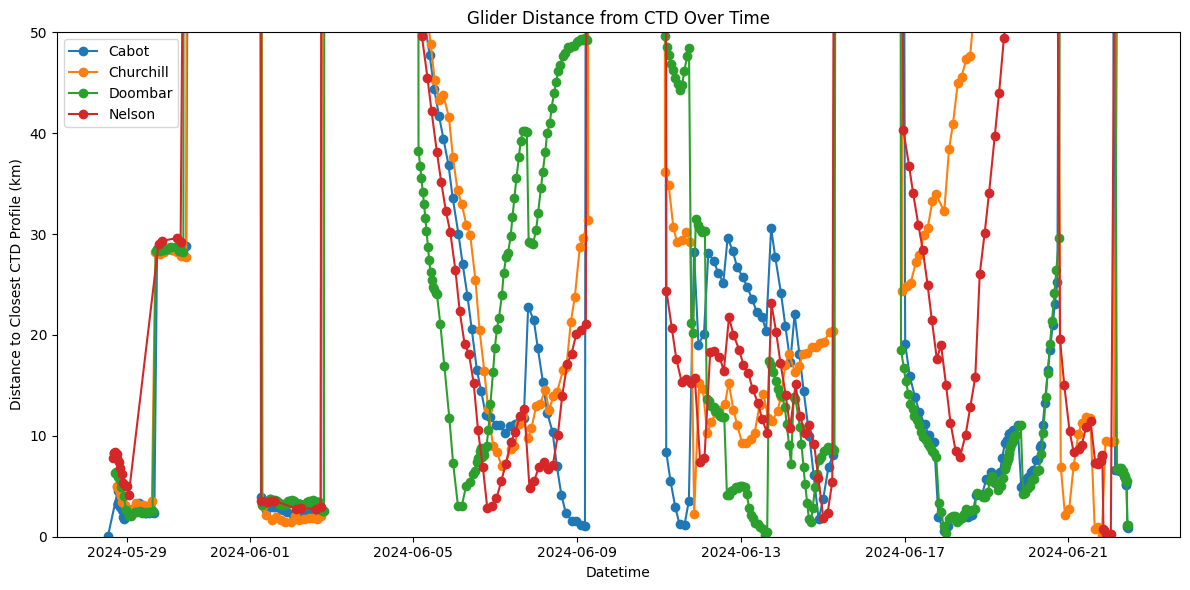

In [ ]:

# Get the last CTD profile datetime
last_ctd_time = ctd_times[-1]

# Filter summary_pd to only include glider profiles up to the last CTD profile datetime
mask = summary_pd['median_datetime'] <= last_ctd_time
filtered = summary_pd[mask]

# Plot
plt.figure(figsize=(12, 6))
for name, group in filtered.groupby('glider_name'):
    plt.plot(group['median_datetime'], group['ctd_distance_km'], label=name, marker='o', linestyle='-')

plt.xlabel('Datetime')
plt.ylabel('Distance to Closest CTD Profile (km)')
plt.ylim(0, 50)
plt.title('Glider Distance from CTD Over Time')
plt.legend()
plt.tight_layout()
plt.show()

### Generate a list of possible candidate profiles

In [26]:
def find_candidate_glider_ctd_pairs(glider_df, ctd_df, time_thresh_hr=2, dist_thresh_km=5):
    """
    Identify all pairs of glider and CTD profiles within specified time (hours) and distance (km) thresholds.

    Parameters
    ----------
    glider_df : pandas.DataFrame
        DataFrame with columns ['profile_id', 'glider_name', 'median_datetime', 'median_longitude', 'median_latitude'].
    ctd_df : pandas.DataFrame
        DataFrame with columns ['datetime', 'lon', 'lat', ...].
    time_thresh_hr : float
        Maximum allowed time difference in hours.
    dist_thresh_km : float
        Maximum allowed spatial distance in kilometers.

    Returns
    -------
    candidates : list of tuples
        Each tuple is (glider_profile_id, glider_name, ctd_profile_idx, time_diff_hr, dist_km)
    """
    candidates = []
    for i, g_row in glider_df.iterrows():
        for j, c_row in ctd_df.iterrows():
            # Time difference in hours
            time_diff_hr = abs((g_row['median_datetime'] - c_row['datetime']).total_seconds()) / 3600.0
            if time_diff_hr > time_thresh_hr:
                continue
            # Distance in km
            if pd.isnull(g_row['median_latitude']) or pd.isnull(g_row['median_longitude']) or pd.isnull(c_row['lat']) or pd.isnull(c_row['lon']):
                continue
            glider_pos = (g_row['median_latitude'], g_row['median_longitude'])
            ctd_pos = (c_row['lat'], c_row['lon'])
            dist_km = geodesic(glider_pos, ctd_pos).km
            if dist_km > dist_thresh_km:
                continue
            candidates.append((
                g_row['profile_id'], g_row['glider_name'],
                c_row['profile_idx'], time_diff_hr, dist_km
            ))
    return candidates


In [27]:
# Use the find_candidate_glider_ctd_pairs function with filtered and ctd_summary
candidates = find_candidate_glider_ctd_pairs(
    filtered,
    ctd_summary,
    time_thresh_hr=12,
    dist_thresh_km=20
)

print(f"Found {len(candidates)} candidate glider-CTD profile pairs within 12hr and 20km.")
# Show the first 5 candidates
candidates[:5]

Found 1038 candidate glider-CTD profile pairs within 12hr and 20km.


[('1.0_Cabot', 'Cabot', 1243, 9.446720483333333, 0.07636790338417539),
 ('1.0_Cabot', 'Cabot', 1749, 7.530053816666666, 0.07461250522180993),
 ('1.0_Cabot', 'Cabot', 1809, 1.26338715, 0.06863469114151115),
 ('1.0_Nelson', 'Nelson', 1749, 10.709147050555556, 7.844837897234578),
 ('1.0_Nelson', 'Nelson', 1809, 4.442480383888889, 7.849181438790229)]

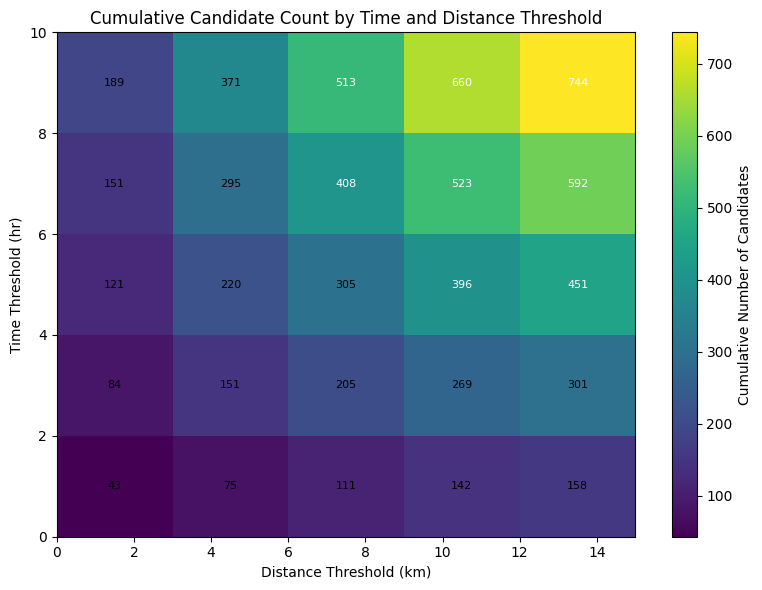

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# Extract time_diff_hr and dist_km from candidates
time_diffs_hr = [c[3] for c in candidates]
distances_km = [c[4] for c in candidates]

# Define bin edges
time_bins = np.arange(0, 12, 2)  # 0 to 24 hours, 2hr bins
dist_bins = np.arange(0, 18, 3)  # 0 to 30 km, 3km bins

# Compute 2D histogram (cumulative count)
H, xedges, yedges = np.histogram2d(time_diffs_hr, distances_km, bins=[time_bins, dist_bins])

# Make cumulative along both axes
H_cum = H.cumsum(axis=0).cumsum(axis=1)

# Plot heatmap
plt.figure(figsize=(8, 6))
X, Y = np.meshgrid(yedges, xedges)
plt.pcolormesh(X, Y, H_cum, cmap='viridis', shading='auto')
plt.colorbar(label='Cumulative Number of Candidates')
plt.xlabel('Distance Threshold (km)')
plt.ylabel('Time Threshold (hr)')
plt.title('Cumulative Candidate Count by Time and Distance Threshold')

# Annotate each cell with the count
for i in range(H_cum.shape[0]):
    for j in range(H_cum.shape[1]):
        plt.text(
            yedges[j] + 1.5,  # center of bin in y
            xedges[i] + 1,    # center of bin in x
            int(H_cum[i, j]),
            color='white' if H_cum[i, j] > H_cum.max()/2 else 'black',
            ha='center', va='center', fontsize=8
        )

plt.tight_layout()
plt.show()

In [46]:
def plot_heatmap_glider(glider_name):
        
    # Filter candidates for this glider
    candidates_glider = [c for c in candidates if c[1] == glider_name]

    # Extract time_diff_hr and dist_km for this glider
    time_diffs_hr_g = [c[3] for c in candidates_glider]
    distances_km_g = [c[4] for c in candidates_glider]

    # Compute 2D histogram (cumulative count)
    H_g, xedges_g, yedges_g = np.histogram2d(time_diffs_hr_g, distances_km_g, bins=[time_bins, dist_bins])
    H_cum_g = H_g.cumsum(axis=0).cumsum(axis=1)

    # Plot heatmap for the specific glider
    plt.figure(figsize=(8, 6))
    Xg, Yg = np.meshgrid(yedges_g, xedges_g)
    plt.pcolormesh(Xg, Yg, H_cum_g, cmap='PuBu', shading='auto')
    plt.colorbar(label='Cumulative Number of Candidates')
    plt.xlabel('Distance Threshold (km)')
    plt.ylabel('Time Threshold (hr)')
    plt.title(f'Cumulative Candidate Count by Time and Distance: {glider_name}')

    # Annotate each cell with the count
    for i in range(H_cum_g.shape[0]):
        for j in range(H_cum_g.shape[1]):
            plt.text(
                yedges_g[j] + 1.5,
                xedges_g[i] + 1,
                int(H_cum_g[i, j]),
                color='white' if H_cum_g[i, j] > H_cum_g.max()/2 else 'black',
                ha='center', va='center', fontsize=8
            )

    plt.tight_layout()
    plt.show()

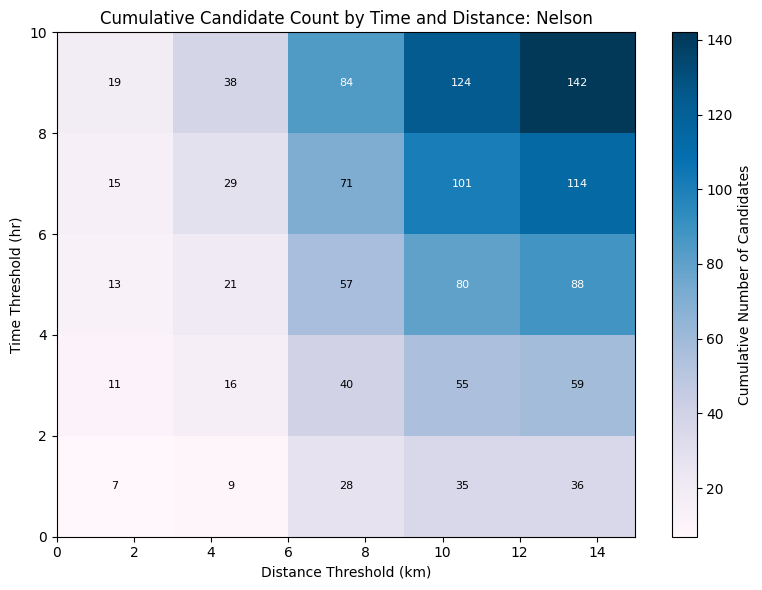

In [47]:
# Choose a specific glider, e.g., "Nelson"
glider_of_interest = "Nelson"
plot_heatmap_glider(glider_of_interest)

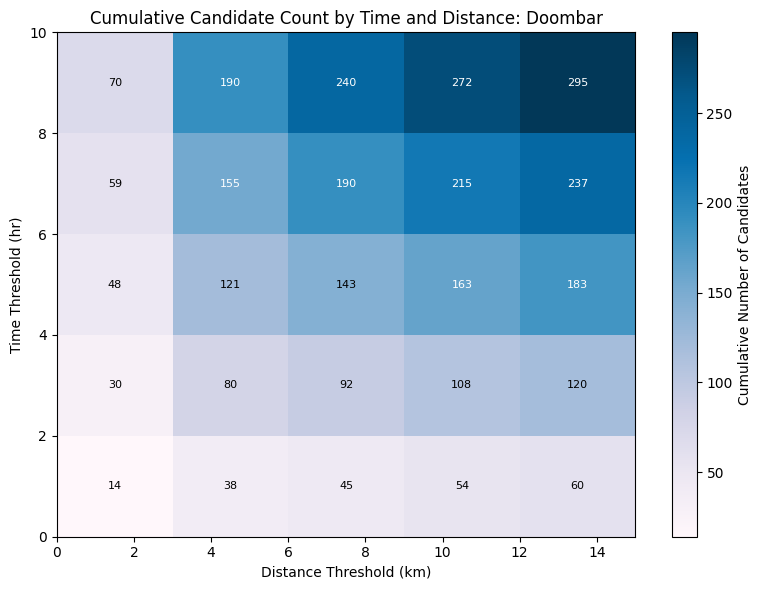

In [48]:
plot_heatmap_glider("Doombar")

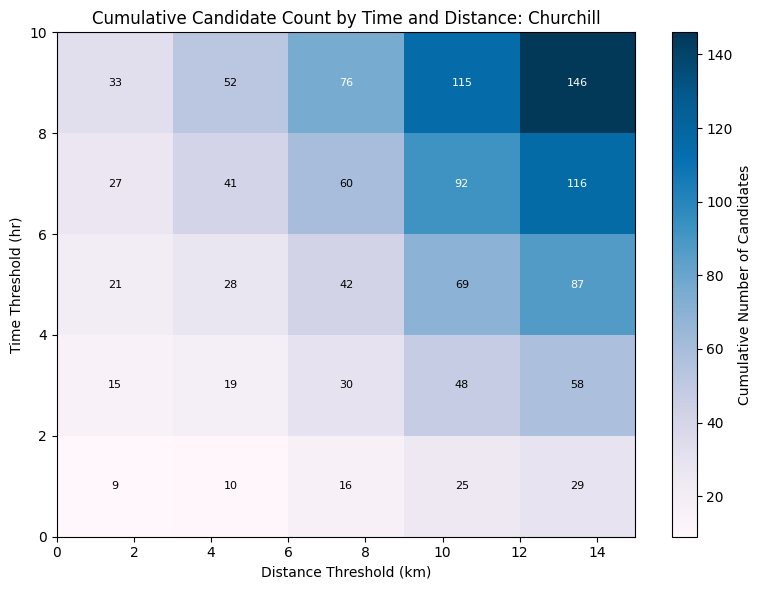

In [49]:
plot_heatmap_glider("Churchill")

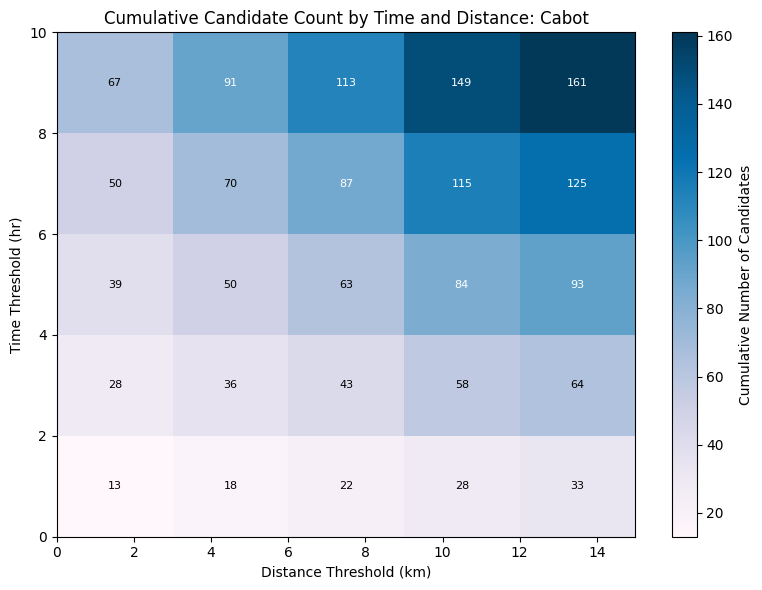

In [50]:
plot_heatmap_glider("Cabot")

### Look at depth bin match up